# Load the required packages

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split   

from tensorflow.keras import models, layers 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Helper Functions

In [20]:
def model_evaluate(model, X_test, y_test):
    model = model
    model.evaluate(X_test, y_test)
    y_pred = model.predict(X_test)
    y_pred_int = np.round(y_pred).astype(int)

    cm = confusion_matrix(y_test, y_pred_int)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

In [22]:
import matplotlib.pyplot as plt
def plot_history(history, title='training history', axs=None, exp_name="accuracy"):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['recall'], label='train')
    ax1.plot(history.history['val_recall'], label='val')
    #ax1.set_ylim(0., 2.2)
    ax1.set_title('Recall')
    ax1.legend()

    ax2.plot(history.history[exp_name], label='train')
    ax2.plot(history.history['val_{exp_name}'], label='val')
    #ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [23]:
def get_image(item):
    file_name = f"../processed_data/{item['Cat']}/{item['image']}.jpg"
    image = Image.open(file_name)
    width, height=image.size
    assert (width==400 and height==400), f"image: {file_name}, width: {width}, height: {height}"
    return np.asarray(image, dtype=np.float32)


# Load Processed Data

### Load meta data

In [24]:
data = pd.read_csv('../processed_data/ISIC_2019_Training_GroundTruth_Processed_Balanced.csv')
data.head()

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,Cat,y
0,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
1,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,1
2,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0
3,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MEL,1
4,ISIC_0000007,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NV,0


the shape of the processed data setis (24806, 12)


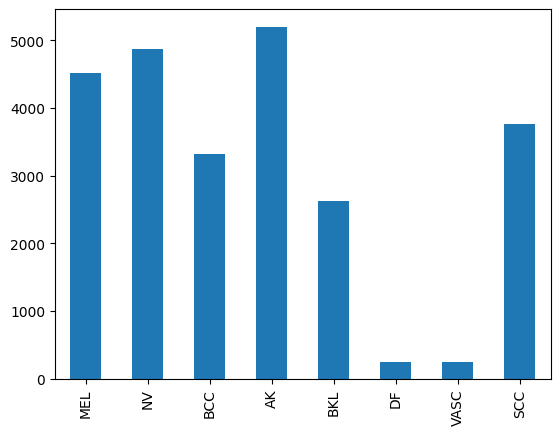

In [25]:
print(f'the shape of the processed data setis {data.shape}')
data.sum()[1:9].plot.bar();

### Load image data

In [26]:
n_samples=100; 
sample = data.sample(n_samples, random_state=42)
# sample = data #load the full dataset

X = sample.apply(get_image, axis=1)
X = np.stack(X)
y = sample.y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(70, 400, 400, 3) (30, 400, 400, 3) (70,) (30,)


# Modeling

## CNN Model

### build CNN Model

In [7]:
def initialize_CNN_model():
    
    model = models.Sequential()

    model.add(layers.Conv2D(16, (3, 3), input_shape = (400,400,3), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding='same' ))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(layers.Conv2D(64, (2, 2), activation = 'relu', padding='same'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    model.add(layers.Flatten())
    model.add(layers.Dense(units = 100, activation = 'relu'))
    model.add(layers.Dense(units = 1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics =['accuracy', 'Recall'])   

    return model

model_cnn = initialize_CNN_model()
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 400, 400, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 100, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 50, 50, 64)       0

### Train CNN Model

In [8]:
es = EarlyStopping(patience=5, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split = 0.3,
    batch_size = 16,
    epochs=10,
    callbacks=[es],
    verbose = 1)

Epoch 1/10
307/307 [==============================] - 322s 1s/step - loss: 3.1727 - accuracy: 0.6684 - recall: 0.9355 - val_loss: 0.6043 - val_accuracy: 0.6771 - val_recall: 0.9979
Epoch 2/10
307/307 [==============================] - 323s 1s/step - loss: 0.6098 - accuracy: 0.6796 - recall: 0.9340 - val_loss: 0.6062 - val_accuracy: 0.7138 - val_recall: 0.9726
Epoch 3/10
307/307 [==============================] - 324s 1s/step - loss: 0.6298 - accuracy: 0.6827 - recall: 0.9283 - val_loss: 0.5989 - val_accuracy: 0.6833 - val_recall: 0.9958
Epoch 4/10
307/307 [==============================] - 301s 979ms/step - loss: 0.5997 - accuracy: 0.6967 - recall: 0.9337 - val_loss: 0.6200 - val_accuracy: 0.6771 - val_recall: 0.9972
Epoch 5/10
307/307 [==============================] - 327s 1s/step - loss: 0.6038 - accuracy: 0.6988 - recall: 0.9235 - val_loss: 0.5992 - val_accuracy: 0.7138 - val_recall: 0.9368
Epoch 6/10
307/307 [==============================] - 308s 1000ms/step - loss: 0.5763 - accu

## VGG16 Transfer Learning

### Build VGG Model

In [27]:
def load_vgg_model():
    model = VGG16(weights="imagenet", include_top=False, input_shape=X_train[0].shape)
    return model

def set_nontrainable_layers(model):
    # Set the first layers to be untrainable
    model.trainable = False

    return model

def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''

    base_model = set_nontrainable_layers(model)
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(200, activation='relu')
    prediction_layer = layers.Dense(1, activation='sigmoid')

    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        prediction_layer
    ])

    return model

def build_vgg_model():

    model = load_vgg_model()
    model = add_last_layers(model)

    opt = optimizers.Adam(learning_rate=0.001)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy', 'Recall'])
    return model

model_vgg = build_vgg_model()
model_vgg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 12, 12, 512)       14714688  
                                                                 
 flatten_1 (Flatten)         (None, 73728)             0         
                                                                 
 dense_2 (Dense)             (None, 200)               14745800  
                                                                 
 dense_3 (Dense)             (None, 1)                 201       
                                                                 
Total params: 29,460,689
Trainable params: 14,746,001
Non-trainable params: 14,714,688
_________________________________________________________________


### Data Preprocessing

In [28]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

### Train VGG Model

In [29]:
model = model_vgg

es = EarlyStopping(monitor = 'f1',
                   mode = 'max',
                   patience = 5,
                   verbose = 1,
                   restore_best_weights = True)

history = model.fit(X_train, y_train,
                    validation_split=0.3,
                    epochs=10,
                    batch_size=32,
                    callbacks=[es])



Epoch 1/10
2/2 [==============================] - 51s 26s/step - loss: 27.3775 - accuracy: 0.5306 - recall: 0.5833 - val_loss: 45.0694 - val_accuracy: 0.7619 - val_recall: 1.0000
Epoch 2/10
2/2 [==============================] - 49s 27s/step - loss: 20.5014 - accuracy: 0.7347 - recall: 1.0000 - val_loss: 15.8834 - val_accuracy: 0.7619 - val_recall: 1.0000
Epoch 3/10
2/2 [==============================] - 48s 27s/step - loss: 0.6958 - accuracy: 0.8571 - recall: 1.0000 - val_loss: 2.9993 - val_accuracy: 0.8571 - val_recall: 1.0000
Epoch 4/10
2/2 [==============================] - 50s 26s/step - loss: 0.0961 - accuracy: 0.9592 - recall: 0.9444 - val_loss: 1.1367 - val_accuracy: 0.5714 - val_recall: 0.6250
Epoch 5/10
2/2 [==============================] - 50s 27s/step - loss: 0.4607 - accuracy: 0.8571 - recall: 0.8056 - val_loss: 0.9196 - val_accuracy: 0.5714 - val_recall: 0.6250
Epoch 6/10
2/2 [==============================] - 45s 24s/step - loss: 0.0161 - accuracy: 1.0000 - recall: 1.00

## Evaluate Model

1/1 [==============================] - 19s 19s/step


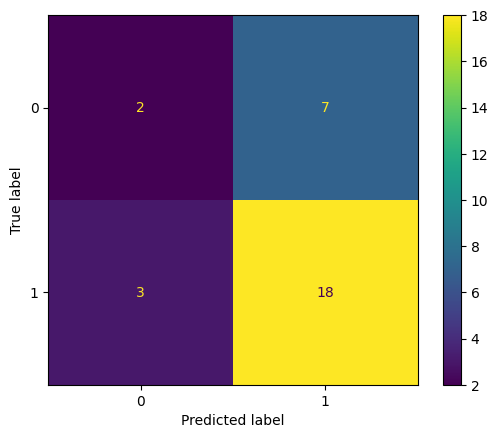

(<Axes: title={'center': 'Recall'}>, <Axes: title={'center': 'Accuracy'}>)

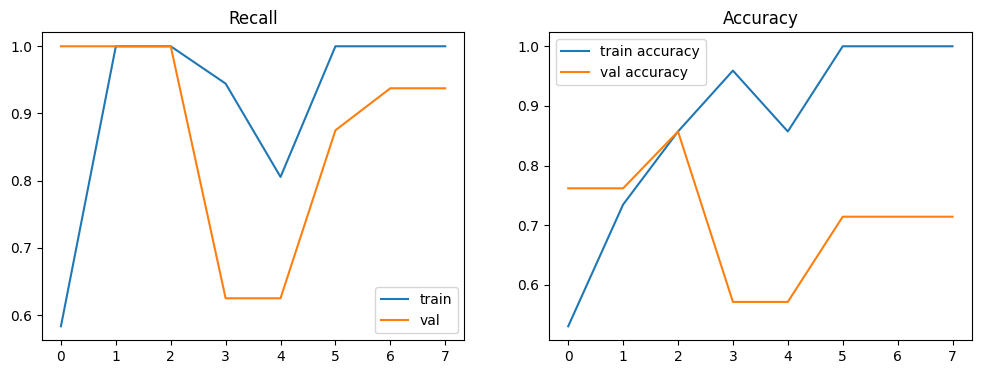

In [30]:
model_evaluate(model, X_test, y_test)
plot_history(history,exp_name='f1')

# Save the trained model

In [ ]:
# Serialize the trained model
model_name= 'model_dummy'
import pickle
file_name_pickle = f'../{model_name}.pickle'
with open(file_name_pickle, 'wb') as file:
    pickle.dump(model, file)